In [1]:
import pickle
import math

import torch
import numpy as np
from veccs import orderings
from gpytorch.kernels import MaternKernel
from sklearn.gaussian_process import kernels
from matplotlib import pyplot as plt

from batram.legmods import Data, SimpleTM
from batram.shrinkmods import ShrinkTM, EstimableShrinkTM

%load_ext autoreload
%autoreload 2

/home/anirban0451/miniconda3/envs/shrink2param/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading data

In [2]:

with open("../data/prec_days.pkl", "rb") as f:
    prec_days = pickle.load(f)

#with open("../data/prec_all.pkl", "rb") as f:
#    prec_all = pickle.load(f)

#lat = prec_days["lat"]
#lon = prec_days["lon"]
#obs = np.log(prec_days["precs"][:,:,0].T + 1e-10)
locs = np.loadtxt("../data/locs.csv", skiprows=1, delimiter=",")
lat = locs[:, 1]
lon = locs[:, 0]
obs = np.loadtxt("../data/prec-june1.csv", skiprows=1, delimiter=",").T
#l=lon/360*2*math.pi; L=lat/360*2*math.pi
#locs = (np.vstack([np.cos(L)*np.cos(l),np.cos(L)*np.sin(l),np.sin(L)])).T

### Ordering

In [3]:
torch.manual_seed(6132024)
locsorder = orderings.maxmin_cpp(locs)
locsTrain = locs[locsorder, :]
nn = orderings.find_nns_l2(locs, 30)
shuffle = torch.randperm(obs.shape[0])

obsTrain = torch.from_numpy((obs[shuffle,:])[:, locsorder]).float()

### Training

In [4]:
nsteps = 200
nTrain = [1, 5, 10, 25, 50, 80]

In [5]:
logscores_tm = []
logscores_shrink = []
numExpReps = 10
tm_models = []
shrink_models = []
numTestSamples = 50
ModifNumTestSampleslist = []

In [6]:
MasterIndices = np.arange(obsTrain.shape[0])
for n in nTrain:
    
    ActNumTestSamples = min(numTestSamples, (obsTrain.shape[0] - n))
    logScore_tm = torch.zeros(numExpReps)
    logScore_shrink = torch.zeros(numExpReps)
    ModifNumTestSamples = (ActNumTestSamples * torch.ones(numExpReps))
    for i in range(numExpReps):
        indices = np.random.choice(MasterIndices, n, replace=False)
        obsTrainSub = obsTrain[indices, :]
        if obsTrainSub.dim() == 1:
            obsTrainSub = obsTrainSub.unsqueeze(0)

        data = Data.new(torch.as_tensor(locsTrain).float(), obsTrainSub, torch.as_tensor(nn))

        tm = SimpleTM(data, theta_init=None, linear=False, smooth=1.5, nug_mult=4.0)
        opt = torch.optim.Adam(tm.parameters(), lr=0.01)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
        res = tm.fit(
            nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=900
        )

        shrink_tm = EstimableShrinkTM(data=data, linear=False, 
                            transportmap_smooth=1.5, 
                            parametric_kernel= "exponential",
                            param_nu=0.5,
                            param_ls=0.6,
                            nug_mult_bounded=False)
        opt2 = torch.optim.Adam(shrink_tm.parameters(), lr=0.01)
        sched2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt2, nsteps)
        res2 = shrink_tm.fit(
            nsteps, 0.1, test_data=shrink_tm.data, optimizer=opt2, scheduler=sched2, batch_size=900,

        )
        tm_models.append(tm)
        shrink_models.append(shrink_tm)
        TestIndices = np.setdiff1d(MasterIndices, indices)
        for _j in range(ActNumTestSamples):
            try:
                with torch.no_grad():
                    logScore_tm[i] += tm.score(obsTrain[(TestIndices[_j]), :])
                logScore_shrink[i] += shrink_tm.score(obsTrain[(TestIndices[_j]), :])
            except:
                ModifNumTestSamples[i] -= 1
                continue

    ModifNumTestSampleslist.append(ModifNumTestSamples)
    logscores_tm.append(logScore_tm)
    logscores_shrink.append(logScore_shrink)
        

Train Loss: 66107.967, Test Loss: 66310.141: 100%|██████████| 200/200 [04:27<00:00,  1.34s/it] 


In [7]:
torch.save({
 'logscores_tm': logscores_tm,
 'logscores_shrink': logscores_shrink,
 'ModifNumTestSampleslist': ModifNumTestSampleslist,
 'nTrain': nTrain,
}, '../results/precipresults_americas.pt')

In [8]:
precipmodels = {
    'tm_models': tm_models,
 'shrink_models': shrink_models,  
}

with open('../results/precipmodels_americas.pkl', 'wb') as f:
    pickle.dump(precipmodels, f)

In [12]:
assert len(logscores_shrink) == len(logscores_tm)
assert len(logscores_shrink) == len(ModifNumTestSampleslist)

### Calculate average log score from experiments

In [21]:
finalscore_tm = torch.zeros((len(logscores_tm[0]), len(nTrain)))
finalscore_shrink = torch.zeros((len(logscores_shrink[0]), len(nTrain)))

In [23]:
for i in range(len(nTrain)):
    finalscore_tm[:, i] = logscores_tm[i] / ModifNumTestSampleslist[i]
    finalscore_shrink[:, i] = logscores_shrink[i] / ModifNumTestSampleslist[i]

In [25]:
finalscore_tm.mean(dim=0), finalscore_shrink.mean(dim=0)

(tensor([-4803.6855, -3928.0286, -3882.9407, -3746.3887, -3642.7539, -3470.2898]),
 tensor([-3346.3040, -3348.7156, -3350.4050, -3320.0364, -3351.0579, -3309.7227]))

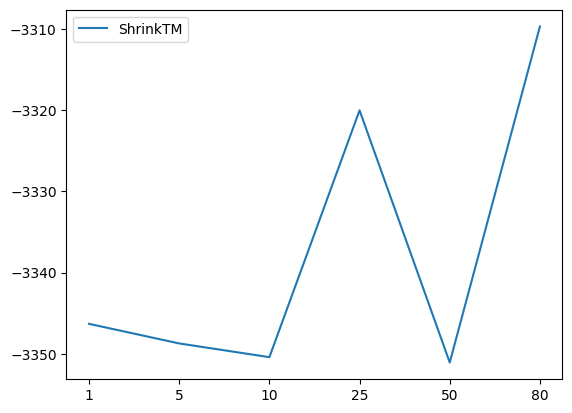

In [31]:
#plt.plot(torch.arange(len(nTrain)), finalscore_tm.mean(dim=0), label="SimpleTM")
plt.plot(torch.arange(len(nTrain)), finalscore_shrink.mean(dim=0), label="ShrinkTM")
plt.legend()
plt.xticks(torch.arange(len(nTrain)), labels = nTrain);